## Dataset

In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Leggi intestazione: magic number, numero immagini, righe, colonne
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        # Leggi tutti i pixel e convertili in array numpy
        images = np.frombuffer(f.read(), dtype=np.uint8)
        # Ridimensiona l'array in (num_images, rows, cols)
        images = images.reshape((num_images, rows, cols))
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels
#-------------- Data Extraction ---------------------------

train_images = load_mnist_images('MNIST/train-images-idx3-ubyte')
train_labels = load_mnist_labels('MNIST/train-labels-idx1-ubyte')

test_images = load_mnist_images('MNIST/t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('MNIST/t10k-labels.idx1-ubyte')

#--------------- Train data manipulation ------------------
print(train_images.shape)  # (60000, 28, 28)
print(train_labels.shape)  # (60000,)
one_hot_labels = np.zeros(train_labels.shape[0]*10).reshape((train_labels.shape[0]),10)
for i in range(len(train_labels)):
    one_hot_labels[i][train_labels[i]]=1
train_labels = one_hot_labels
print(train_labels.shape) # (60000,10)

#--------------- Test data manipulation -------------------
print(test_images.shape)  # (10000, 28, 28)
print(test_labels.shape)  # (10000,)
one_hot_labels = np.zeros(test_labels.shape[0]*10).reshape((test_labels.shape[0]),10)
for i in range(len(test_labels)):
    one_hot_labels[i][test_labels[i]]=1
test_labels = one_hot_labels
print(test_labels.shape) # (10000,10)

(60000, 28, 28)
(60000,)
(60000, 10)
(10000, 28, 28)
(10000,)
(10000, 10)


## CNN - PyTorch

The PyTorch model will be used as a reference to compute the weights since it's the fastest in training and the least prone to errors. If everything is written well, both slow and fast implementations of a CNN in numpy will give the same result, since the weights are the same.

### Model and Dataset Declaration with Training

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
from tqdm import tqdm 

# 1.------------------ CNN declaration -------------------

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # --------- Convolutional Layers ------------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        # ---------- Flatten to become MLP's input -----------
        self.flatten = nn.Flatten()

        fc_input_size = 128 * 4 * 4
        # ---------- Multi Layer Perceptron ---------------
        # Only one hidden layer for classification
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=250)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=250, out_features=num_classes)

    def forward(self, x):
        # First convolution
        x = self.conv1(x)
        x = self.relu1(x)

        # Second Convolution
        x = self.conv2(x)
        x = self.relu2(x)

        # Third Convolution
        x = self.conv3(x)
        x = self.relu3(x)

        # Flatten
        x = self.flatten(x)

        # MLP
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

# 2.------------------ CNN's Dataset declaration ----------------------

# class CNNDataset(Dataset):
#     def __init__(self, digits, labels, transform=None):
#         assert len(digits) == len(labels), "Number of digits and labels doesn't match"
#         self.digits = digits
#         self.labels = labels

#     def __len__(self):
#         return len(self.digits)

#     def __getitem__(self, idx):
#         digit = self.digits[idx]
#         label = self.labels[idx]
#         digit = digit.unsqueeze(0) # Needed operation to add the dimension of greyscale images (28,28) -> (1,28,28)
#         return digit, label

# tri = torch.from_numpy(train_images).float() / 255
# trl = torch.from_numpy(train_labels).float()
# tsi = torch.from_numpy(test_images).float() / 255
# tsl = torch.from_numpy(test_labels).float()

# train_dataset = CNNDataset(tri,trl)
# test_dataset = CNNDataset(tsi,tsl)

# batch_size = 128
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # 3.------ Training Setup ---------------

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print(f"device: {device}")

# model = SimpleCNN(num_classes=10).to(device)

# # Loss definition
# criterion = nn.CrossEntropyLoss() 

# # Optimisation definition
# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num_epochs = 5 

# # 4.------- cycle training ------

# print("\nStarting Training...")
# for epoch in range(num_epochs):

#     model.train() 

#     running_loss = 0.0
#     start_time = time.time()
#     #tqdm is module used to have a progress bar
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

#     for inputs, labels in progress_bar:

#         # move data on the device
#         inputs, labels = inputs.to(device), labels.to(device)

#         # make all gradients zero to avoid learning on gradients of previous steps
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs) 
#         # loss computation
#         loss = criterion(outputs, labels)

#         # Backward pass: compute the gradients
#         loss.backward()

#         # Weights update
#         optimizer.step()

#         # Update the loss
#         running_loss += loss.item() * inputs.size(0) # multiply for batch size to obtain the correct mean

#         # Update the progress bar
#         progress_bar.set_postfix(loss=f"{loss.item():.4f}")

#     # Epochs' mean loss computation
#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_time = time.time() - start_time

#     print(f"Epoch {epoch+1}/{num_epochs} - Tempo: {epoch_time:.2f}s - Training Loss: {epoch_loss:.4f}")

#     # --- Test evaluation (after every epoch) ---
#     model.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad(): # Disable gradient computation (we don't need gradients since we don't want to update the model in this phase)
#         i=0
#         for inputs, labels in test_loader:
#             if i >= 1:
#                 continue
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs.data, 1) # Obtain index with the maximum probability (it is our result)
#             _,labels = torch.max(labels,1) # same for the test labels
#             total += labels.size(0)
#             correct += (predicted==labels).sum().item()
#             i+=1

#     avg_test_loss = test_loss / len(test_loader.dataset)
#     accuracy = 100 * correct / total
#     print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {avg_test_loss:.4f} - Test Accuracy: {accuracy:.2f}%")


# print("\nTraining Complete.")
# #2m 9.4 secondi per avere un'epoca con cuda
# # save the model
# torch.save(model.state_dict(), 'simple_cnn_mnist.pth')

### Weights extraction

In [3]:
model = SimpleCNN(num_classes=10)
model.load_state_dict(torch.load('simple_cnn_mnist.pth', map_location=torch.device('cpu'),weights_only=True)) # Carica su CPU

model.eval() # good practice is to set model in evaluation when you want to extract weights

# --- Parameters Extraction ⛏️ and Numpy Conversion ---

# Weights container
numpy_weights = {}

# Move model on cpu
model.to('cpu')

print("⛏️ Weights and Bias Extraction ⛏️\n")

# Layer Conv1
# PyTorch weight shape: (out_channels, in_channels, kernel_height, kernel_width)
# NumPy expected: (in_channels, out_channels, kernel_width, kernel_height) -> (1, 32, 3, 3)
pyt_k1_w = model.conv1.weight.data.detach().numpy()
# Transpose: (out, in, kH, kW) -> (in, out, kW, kH)
numpy_weights['k1'] = pyt_k1_w
print("----------------------------------------")
print(pyt_k1_w[0][:1])
print("----------------------------------------")
print(numpy_weights['k1'][0][:1])
# PyTorch bias shape: (out_channels,)
numpy_weights['b_conv1'] = model.conv1.bias.data.detach().numpy() # Shape (32,)
print(f"k1: PyTorch Shape={pyt_k1_w.shape}, NumPy Shape={numpy_weights['k1'].shape}")
print(f"b_conv1: NumPy Shape={numpy_weights['b_conv1'].shape}")

# Layer Conv2
# PyTorch weight shape: (64, 32, 3, 3)
# NumPy expected: (32, 64, 3, 3)
pyt_k2_w = model.conv2.weight.data.detach().numpy()
numpy_weights['k2'] = pyt_k2_w
numpy_weights['b_conv2'] = model.conv2.bias.data.detach().numpy() # Shape (64,)
print(f"k2: PyTorch Shape={pyt_k2_w.shape}, NumPy Shape={numpy_weights['k2'].shape}")
print(f"b_conv2: NumPy Shape={numpy_weights['b_conv2'].shape}")

# Layer Conv3
# PyTorch weight shape: (128, 64, 3, 3)
# NumPy expected: (64, 128, 3, 3)
pyt_k3_w = model.conv3.weight.data.detach().numpy()
numpy_weights['k3'] = pyt_k3_w
numpy_weights['b_conv3'] = model.conv3.bias.data.detach().numpy() # Shape (128,)
print(f"k3: PyTorch Shape={pyt_k3_w.shape}, NumPy Shape={numpy_weights['k3'].shape}")
print(f"b_conv3: NumPy Shape={numpy_weights['b_conv3'].shape}")

# Layer FC1
# PyTorch weight shape: (out_features, in_features) -> (250, 2048)
# NumPy expected (per input @ W): (in_features, out_features) -> (2048, 250)
pyt_w1 = model.fc1.weight.data.detach().numpy()
numpy_weights['w1'] = pyt_w1.T # Trasponi
# PyTorch bias shape: (out_features,) -> (250,)
# NumPy expected (per aggiunta diretta): (1, out_features) -> (1, 250)
pyt_b1 = model.fc1.bias.data.detach().numpy()
numpy_weights['b1'] = pyt_b1.reshape(1, -1) # Rendi (1, 250)
print(f"w1: PyTorch Shape={pyt_w1.shape}, NumPy Shape={numpy_weights['w1'].shape}")
print(f"b1: PyTorch Shape={pyt_b1.shape}, NumPy Shape={numpy_weights['b1'].shape}")

# Layer FC2
# PyTorch weight shape: (num_classes, 250) -> (10, 250)
# NumPy expected: (250, num_classes) -> (250, 10)
pyt_w2 = model.fc2.weight.data.detach().numpy()
numpy_weights['w2'] = pyt_w2.T # Trasponi
# PyTorch bias shape: (num_classes,) -> (10,)
# NumPy expected: (1, num_classes) -> (1, 10)
pyt_b2 = model.fc2.bias.data.detach().numpy()
numpy_weights['b2'] = pyt_b2.reshape(1, -1) # Rendi (1, 10)
print(f"w2: PyTorch Shape={pyt_w2.shape}, NumPy Shape={numpy_weights['w2'].shape}")
print(f"b2: PyTorch Shape={pyt_b2.shape}, NumPy Shape={numpy_weights['b2'].shape}")

print("\nExtraction complete. Numpy weights are in the dictionary 'numpy_weights'.")

# Access Example:
np_k1 = numpy_weights['k1']
np_b_conv1 = numpy_weights['b_conv1']
np_k2 = numpy_weights['k2']
np_b_conv2 = numpy_weights['b_conv2']
np_k3 = numpy_weights['k3']
np_b_conv3 = numpy_weights['b_conv3']
np_w1 = numpy_weights['w1']
np_b1 = numpy_weights['b1']
np_w2 = numpy_weights['w2']
np_b2 = numpy_weights['b2']



# [[[[-0.06239345  0.16331542  0.28573602]
#    [ 0.299534    0.48019555  0.25194943]
#    [-0.24432278  0.3191273  -0.06802213]]]


#  [[[ 0.10294101 -0.14240074  0.01178457]
#    [ 0.3072691  -0.06823204  0.30347323]
#    [-0.06327374  0.3396498   0.07433306]]]



#    [[[[-0.06239345  0.16331542  0.28573602]
#    [ 0.299534    0.48019555  0.25194943]
#    [-0.24432278  0.3191273  -0.06802213]]

#   [[ 0.10294101 -0.14240074  0.01178457]
#    [ 0.3072691  -0.06823204  0.30347323]
#    [-0.06327374  0.3396498   0.07433306]]

⛏️ Weights and Bias Extraction ⛏️

----------------------------------------
[[[-0.06239345  0.16331542  0.28573602]
  [ 0.299534    0.48019555  0.25194943]
  [-0.24432278  0.3191273  -0.06802213]]]
----------------------------------------
[[[-0.06239345  0.16331542  0.28573602]
  [ 0.299534    0.48019555  0.25194943]
  [-0.24432278  0.3191273  -0.06802213]]]
k1: PyTorch Shape=(32, 1, 3, 3), NumPy Shape=(32, 1, 3, 3)
b_conv1: NumPy Shape=(32,)
k2: PyTorch Shape=(64, 32, 3, 3), NumPy Shape=(64, 32, 3, 3)
b_conv2: NumPy Shape=(64,)
k3: PyTorch Shape=(128, 64, 3, 3), NumPy Shape=(128, 64, 3, 3)
b_conv3: NumPy Shape=(128,)
w1: PyTorch Shape=(250, 2048), NumPy Shape=(2048, 250)
b1: PyTorch Shape=(250,), NumPy Shape=(1, 250)
w2: PyTorch Shape=(10, 250), NumPy Shape=(250, 10)
b2: PyTorch Shape=(10,), NumPy Shape=(1, 10)

Extraction complete. Numpy weights are in the dictionary 'numpy_weights'.


## CNN - NumPy

### Padding

`np.pad()` takes as first argument the matrix to pad and as second argument a set of specification: for every dimension (in our case 4) it takes the number of paddings to add before and after the end of the dimension. If the objective is to pad only the image itself, which is found in the last two dimension, we should write:

`np.pad(img9,((0,0),(0,0),(pad,pad),(pad,pad)))` 

since dimensions are: BATCH, CHANNELS, HEIGHT, WIDTH

In [4]:
img9 = np.arange(1,37).reshape(2,2,3,3)
pad_img9 = np.pad(img9,((0,0),(0,0),(1,1),(1,1)))
print(img9)
print(pad_img9)

[[[[ 1  2  3]
   [ 4  5  6]
   [ 7  8  9]]

  [[10 11 12]
   [13 14 15]
   [16 17 18]]]


 [[[19 20 21]
   [22 23 24]
   [25 26 27]]

  [[28 29 30]
   [31 32 33]
   [34 35 36]]]]
[[[[ 0  0  0  0  0]
   [ 0  1  2  3  0]
   [ 0  4  5  6  0]
   [ 0  7  8  9  0]
   [ 0  0  0  0  0]]

  [[ 0  0  0  0  0]
   [ 0 10 11 12  0]
   [ 0 13 14 15  0]
   [ 0 16 17 18  0]
   [ 0  0  0  0  0]]]


 [[[ 0  0  0  0  0]
   [ 0 19 20 21  0]
   [ 0 22 23 24  0]
   [ 0 25 26 27  0]
   [ 0  0  0  0  0]]

  [[ 0  0  0  0  0]
   [ 0 28 29 30  0]
   [ 0 31 32 33  0]
   [ 0 34 35 36  0]
   [ 0  0  0  0  0]]]]


### Slow Convolution Layer: Forward

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# This is a PyTorch Convolution example to be used to check if the convolution implemented in both slow and fast approaches are correct

class CustomConv(nn.Module):
    def __init__(self, kernel: torch.Tensor, bias: torch.Tensor = None, 
                 stride=1, padding=0):
        super().__init__()
        out_ch, in_ch, k_h, k_w = kernel.shape
        self.stride = stride
        self.padding = padding
        
        self.conv = nn.Conv2d(in_channels=in_ch,
                              out_channels=out_ch,
                              kernel_size=(k_h, k_w),
                              stride=stride,
                              padding=padding,
                              bias=(bias is not None))
        with torch.no_grad():
            self.conv.weight.copy_(kernel)
            if bias is not None:
                self.conv.bias.copy_(bias)

        self.conv.weight.requires_grad_(False)
        if bias is not None:
            self.conv.bias.requires_grad_(False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.conv(x))

def Slow_ReLU_Conv(img,ker,bias=np.array(0),pad=0,stride=1,applyReLU=True):
    if applyReLU: # Forward case
        out_ch, in_ch, k_width, k_height = ker.shape
        nk_channel = out_ch
    else: # Backward case
        in_ch, out_ch, k_width, k_height = ker.shape
        nk_channel = in_ch

    # bias has shape out_ch, 1, 1. It's a scalar value for each channel broadcasted to the kernel's width and height
    # number of channels taken in input by the kernel 'in_ch' 
    # must be the same as the number of channels of the image 'channels'

    img = np.pad(img,((0,0),(0,0),(pad,pad),(pad,pad)))
    n_images, channels, i_height, i_width  = img.shape
    ni_height = int(((i_height - k_height) / stride) + 1) # new image height # Padding is already added
    ni_width = int(((i_width - k_width) / stride) + 1) # new image width
    ni = np.zeros((n_images, out_ch, ni_height, ni_width)).astype(np.float32) # new image

    if in_ch != channels:
        raise ValueError(f"number of channels taken in input by the kernel ({in_ch}) must be the same as the number of channels of the image ({channels})")

    for one_img in range(n_images):
        for one_k_channel in range(nk_channel):
            for i_nih in range(ni_height): # which cycles row by row of the new image
                for i_niw in range(ni_width): # which cycles column by column of the new image
                    current_sum = 0.0 # convolution sum for the specific output cell
                    # Convolution cycles
                    for channel in range(channels): # channels == in_ch
                        for i_kh in range(k_height):
                            input_y = (i_nih * stride) + i_kh # get the y location, the height
                            for i_kw in range(k_width):
                                input_x = (i_niw * stride) + i_kw # get the x location, the width
                                # check that everything stays in the measures
                                if 0 <= input_y < i_height and 0 <= input_x < i_width:
                                    input_val = img[one_img, channel, input_y, input_x]
                                    kernel_val = ker[one_k_channel, channel, i_kh, i_kw]
                                    current_sum += (input_val * kernel_val).astype(np.float32)
                    ni[one_img, one_k_channel, i_nih, i_niw] = current_sum
    if bias.all() != 0:
        bias = bias.reshape(bias.shape[0],1,1)
        if bias.shape[0] != out_ch:
            raise ValueError(f"bias dimension ({bias.shape[0]}) doesn't match kernel's number of channels ({out_ch})")
        ni = ni + bias
    ni = ni.astype(np.float32)
    if applyReLU:
        ni = np.maximum(0, ni)
        mask = ni.copy()
        mask[mask > 0] = 1
        return ni,mask
    else:
        return ni
#-------------------------------------------- Examples --------------------------------------------------------
img = np.arange(1,3*4+1).reshape(1,1,3,4).astype(np.float32)
print("-------img-------")
print(img)
ker = np.arange(1,8+1).reshape(2,1,2,2)
print("-------ker-------")
print(ker)
bias = np.array([1,2]).reshape(2,1,1)
res,mask = Slow_ReLU_Conv(img,ker,bias,pad=1,stride=2)
print("-------Conv Slow-------")
print(res)
# print("------mask-------")
# print(mask)


my_kernel = torch.from_numpy(ker).float()

my_bias = torch.from_numpy(np.array([1,2])).float()

modelC = CustomConv(kernel=my_kernel,bias=my_bias, stride=2, padding=1)

# input di prova (batch=1, canali=1, H=5, W=5)
x = torch.from_numpy(img)
y = modelC(x)
print("-------Conv PyTorch-------")
print(y)

-------img-------
[[[[ 1.  2.  3.  4.]
   [ 5.  6.  7.  8.]
   [ 9. 10. 11. 12.]]]]
-------ker-------
[[[[1 2]
   [3 4]]]


 [[[5 6]
   [7 8]]]]
-------Conv Slow-------
[[[[  5.  19.  13.]
   [ 47.  95.  45.]]

  [[ 10.  40.  30.]
   [104. 232. 126.]]]]
-------Conv PyTorch-------
tensor([[[[  5.,  19.,  13.],
          [ 47.,  95.,  45.]],

         [[ 10.,  40.,  30.],
          [104., 232., 126.]]]])


### Slow Convolution Layer: Backward

**Actors:**
1. W is the kernel
2. $\delta$ is the gradient
3. x is the input to the convolution layer during forward
4. b is the bias

**Steps:**

- **Derive delta**

Deriving delta with respect to ReLU activation consists in the hadamard product (element-wise product) of the gradient ($\delta$) and the mask obtained at the forward step, that is, all the elements in the convolved image greater than zero are put to one, the rest is zero.
$$
\delta^{(i)} = \delta_{\text{flat reshaped}} \cdot \text{mask}
$$

- **Gradient with respect to W**:

$$
\frac{\partial L}{\partial W^{(i)}} = \text{Convolution}(x^{(i)}, \delta)
$$
This convolution creates a matrix for every channel of input image $x^{i}$ and for every channel of output image $\delta$, thus resulting in the correct number of channels

- **Gradient w.r.t. the input \( x \)** (To go to the preceding layer):

$$
\delta^{(i-1)} = \text{Full\_Convolution}(\delta^{(i)}, W^{(i)})
$$
Could also use Transposed Convolution, which is also known as *fractionally strided convolution*

<img src="IMAGES\tc2.png" style="width:600px; left:1000px">

- **Gradient w.r.t the bias**

Since the bias is added equally across the spatial dimensions of each output channel, the gradient is the sum of all elements in each output channel:

$$
\frac{\partial L}{\partial b^{(i)}_c} = \sum_{h,w} \delta^{(i)}_{c,h,w}
$$

For batched inputs, sum also across the batch dimension:

$$
\frac{\partial L}{\partial b^{(i)}_c} = \sum_{n,h,w} \delta^{(i)}_{n,c,h,w}
$$

In [73]:
def Slow_ReLU_FullConv(img,d_img,ker,mask,pad=0,stride=1):
    """
    Performs the backward pass of the convolution layer. It takes the original image, 
    the gradient image, and then the kernel, padding and stride used in the convolution. Also the mask is needed to perform the ReLU operation.
    It returns the gradient w.r.t. the Original Image to back propagate and the gradient of the kernel
    """ 

    out_ch, in_ch, k_height, k_width  = ker.shape 
                                            # Example #
    # Convolving a an RGB image with 32 2x2 kernels will give a shape of (32, 3, 2, 2) to the kernel. #
    
    n_images, channels, i_height, i_width  = img.shape
    n_images, dch, di_height, di_width  = d_img.shape
    
    ni_height = (i_height-1)*stride-(2*pad)+k_height # new image height
    ni_width =  (i_width-1)*stride-(2*pad)+k_width# new image width
    height_to_pad = ni_height-i_height
    width_to_pad = ni_width-i_width
    d_img = np.multiply(d_img,mask)
    d_imgP = np.pad(d_img,((0,0),(0,0),(width_to_pad,width_to_pad),(height_to_pad,height_to_pad)))
    gi = np.zeros_like(img).astype(np.float32) # gradient of original image
    gk = np.zeros_like(ker).astype(np.float32) # gradient of kernel

############################## Computing the gradient of the original image ######################################
    for one_img in range(n_images):
        for channel in range(channels):
            for i_nih in range(i_height): # which cycles row by row of the new image
                for i_niw in range(i_width): # which cycles column by column of the new image
                    current_sum = 0.0 # convolution sum for the specific output cell
                    # Convolution cycles
                    for one_k_channel in range(out_ch): # channels == out_ch
                        for i_kh in range(k_height):
                            input_y = (i_nih * stride) + i_kh # get the y location, the height
                            for i_kw in range(k_width):
                                input_x = (i_niw * stride) + i_kw # get the x location, the width
                                # check that everything stays in the measures
                                if 0 <= input_y < i_height and 0 <= input_x < i_width:
                                    input_val = d_imgP[one_img, one_k_channel, input_y, input_x]
                                    kernel_val = ker[one_k_channel,channel, i_kh, i_kw]
                                    current_sum += (input_val * kernel_val).astype(np.float32)
                    gi[one_img, channel, i_nih, i_niw] = current_sum
    
############################## Computing the gradient of the kernel ##############################################
# Need to convolve the gradient of the image with the original image, using the gradient of the image as the kernel and 
# keeping the same stride and padding (Otherwise the kernel won't work)
    for one_img in range(n_images):
        for in_k_ch in range(in_ch): # which in the example is 3
            for out_k_ch in range(out_ch): # which in the example is 32
                for k_gh in range(k_height):
                    for k_gw in range(k_width):
                    # gk[out_k_ch,in_k_ch,k_gh,k_gw] = something
                        for i_dh in range(di_height):
                            input_y = (k_gh * stride) + i_dh # get the y location, the height
                            for i_dw in range(di_width):
                                input_x = (k_gw * stride) + i_dw
                                # check that everything stays in the measures
                                if 0 <= input_y < k_height and 0 <= input_x < k_width:
                                    input_val = img[one_img, in_k_ch, input_y, input_x]
                                    kernel_val = d_img[one_img,out_k_ch, i_dh, i_dw]
                                    current_sum += (input_val * kernel_val).astype(np.float32)
                        gk[out_k_ch, in_k_ch, k_gh, k_gw] += current_sum
############################## Computing the gradient of the bias ##############################################
    gb = d_img.sum((0,-1,-2)) # sum over batch, height and width
################################################### Return Results ###############################################
    return gi,gk,gb

img = np.arange(1,17).reshape(1,1,4,4)
ker = np.arange(1,9).reshape(2,1,2,2)
bias = np.array([1,1])
d_img,mask=Slow_ReLU_Conv(img,ker,bias,pad=2)
print("-------------d_img--------------")
d_img = d_img - 2
print(d_img)
print(d_img.shape)
print("--------------------------------")
a,b,c = Slow_ReLU_FullConv(img,d_img,ker,mask)
print(a)
print(b)
print(c)


-------------d_img--------------
[[[[ -1.  -1.  -1.  -1.  -1.  -1.  -1.]
   [ -1.   3.  10.  17.  24.  11.  -1.]
   [ -1.  21.  43.  53.  63.  27.  -1.]
   [ -1.  45.  83.  93. 103.  43.  -1.]
   [ -1.  69. 123. 133. 143.  59.  -1.]
   [ -1.  25.  40.  43.  46.  15.  -1.]
   [ -1.  -1.  -1.  -1.  -1.  -1.  -1.]]

  [[ -1.  -1.  -1.  -1.  -1.  -1.  -1.]
   [ -1.   7.  22.  37.  52.  27.  -1.]
   [ -1.  45.  99. 125. 151.  75.  -1.]
   [ -1. 101. 203. 229. 255. 123.  -1.]
   [ -1. 157. 307. 333. 359. 171.  -1.]
   [ -1.  77. 148. 159. 170.  79.  -1.]
   [ -1.  -1.  -1.  -1.  -1.  -1.  -1.]]]]
(1, 2, 7, 7)
--------------------------------
[[[[ -12.  -22.  -22.  -10.]
   [ -20.   44.  260.  178.]
   [ -20.  476. 1532.  942.]
   [  -8.  306.  926.  538.]]]]
[[[[548. 540.]
   [529. 523.]]]


 [[[557. 549.]
   [538. 532.]]]]
[1311. 3487.]


### Fast Convolution Layer: Forward

In [6]:
def Fast_ReLU_Conv(batch_of_images,kernel,bias,pad=0,stride=1):
    kc, ac, kw, kh = kernel.shape # number of kernels, number of input channels, kernel width and kernel height
    # im2col: Window creation
    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(pad,pad),(pad,pad)))
    bs, nc, iw, ih = batch_of_images.shape # batch of images' number of images, number of channels, single image's width, single images's height
    window_m = np.lib.stride_tricks.sliding_window_view(batch_of_images,(1,nc,kw,kh))[:,:,::stride,::stride].reshape((-1,(kw*kh*nc))) # window matrix
    # Convolution
    kernel = kernel.reshape((-1,(kw*kh*nc))).transpose(1,0)
    c_m = (window_m @ kernel).astype(np.float32) # convolved image matrix
    # ReLU activation
    nih = int(((ih-kh) / stride) + 1) # new image height # Padding is already added
    niw = int(((iw-kw) / stride) + 1) # new image width
    # First operate a reshape keeping spatial ordering, which has channels at the end
    output_temp = c_m.reshape(bs, nih, niw, kc)
    # Transpose to have input in shapes (batch, output_channel, height, width)
    reshaped_correct_order = output_temp.transpose(0,3,1,2)
    reshaped_correct_order = (reshaped_correct_order + bias.reshape(1,-1,1,1)).astype(np.float32)
    reshaped_correct_order = np.maximum(0,reshaped_correct_order)
    mask = np.copy(reshaped_correct_order)
    mask[mask>0]=1
    return reshaped_correct_order,mask



img = np.arange(1,2*3*3+1).reshape(1,2,3,3).astype(np.float32)
# print("-------img-------")
# print(img)
ker = np.arange(1,16+1).reshape(2,2,2,2)
# print("-------ker-------")
# print(ker)
bias = np.array([1,2]).reshape(2,1,1)
res,mask = Slow_ReLU_Conv(img,ker,bias,pad=0,stride=1)
print("-------Conv Slow-------")
print(res)
X_c,mask = Fast_ReLU_Conv(img,ker,bias,pad = 0,stride=1)
print("-------Conv Fast-------")
print(X_c)
res,mask = Slow_ReLU_Conv(res,ker,bias,pad=0,stride=1)
print("-------Conv Slow-------")
print(res)
X_c,mask = Fast_ReLU_Conv(X_c,ker,bias,pad = 0,stride=1)
print("-------Conv Fast-------")
print(X_c)

-------Conv Slow-------
[[[[ 357.  393.]
   [ 465.  501.]]

  [[ 838.  938.]
   [1138. 1238.]]]]
-------Conv Fast-------
[[[[ 357.  393.]
   [ 465.  501.]]

  [[ 838.  938.]
   [1138. 1238.]]]]
-------Conv Slow-------
[[[[32231.]]

  [[79176.]]]]
-------Conv Fast-------
[[[[32231.]]

  [[79176.]]]]


### Fast Convolution Layer: Backward

In [ ]:
def Fast_ReLU_FullConv(batch_of_images,kernel,bias,pad=0,stride=1):
    kc, ac, kh, kw = kernel.shape # number of kernels, number of input channels, kernel width and kernel height
    # im2col: Window creation
    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(pad,pad),(pad,pad)))
    bs, nc, iw, ih = batch_of_images.shape # batch of images' number of images, number of channels, single image's width, single images's height
    window_m = np.lib.stride_tricks.sliding_window_view(batch_of_images,(1,nc,kw,kh))[:,:,::stride,::stride].reshape((-1,(kw*kh*nc))) # window matrix
    # Convolution
    kernel = kernel.reshape((-1,(kw*kh*nc))).transpose(1,0)
    c_m = (window_m @ kernel).astype(np.float32) # convolved image matrix
    # ReLU activation
    nih = int(((ih-kh) / stride) + 1) # new image height # Padding is already added
    niw = int(((iw-kw) / stride) + 1) # new image width
    # First operate a reshape keeping spatial ordering, which has channels at the end
    output_temp = c_m.reshape(bs, nih, niw, kc)
    # Transpose to have input in shapes (batch, output_channel, height, width)
    reshaped_correct_order = output_temp.transpose(0,3,1,2)
    reshaped_correct_order = (reshaped_correct_order + bias.reshape(1,-1,1,1)).astype(np.float32)
    reshaped_correct_order = np.maximum(0,reshaped_correct_order)
    mask = np.copy(reshaped_correct_order)
    mask[mask>0]=1
    return reshaped_correct_order,mask

### MLP Layer: Forward

In [19]:
def softmax(x):
    e_x = np.exp(x - np.max(x,axis=-1,keepdims=True))  # for numerical stability
    return e_x / np.sum(e_x,axis=-1,keepdims=True)

def ReLU_SoftMax_FullyConnected(input_array,w1,b1,w2,b2):
    fl = (input_array @ w1)+b1 # first layer
    fa = np.maximum(0,fl) # first activation: ReLU
    sl = (fa @ w2)+b2 # second layer
    sa = softmax(sl) # second activation: SoftMax
    return fl,fa,sl,sa

#print(softmax([1,2,3,100000]))
#print(softmax_no_NS([1,2,3,1000]))
#r = np.array(np.array([1,2,777,2]))
#print(softmax(r))
#r = np.array((np.array([1,2,777,2]),np.array([1,2,777,2]),np.array([1,2,777,2])))
#print(softmax(r))

### MLP Layer: Backward

In [98]:
def ReLU_SoftMax_FC_Backward(bs,pred,labels,w1,w2,fa,fl,i_mlp):
    dL_dz2 = pred-labels[0:bs]
    dL_dw2 = fa.T @ dL_dz2
    dL_db2 = np.sum(dL_dz2, axis=0)
    dL_dfa = dL_dz2 @ w2.T
    dReLU = (fl > 0).astype(float)
    dL_dfl = dL_dfa * dReLU
    dL_dw1 = i_mlp.reshape(bs, -1).T @ dL_dfl
    dL_db1 = np.sum(dL_dfl, axis=0)
    dL_i_mlp = dL_dfl @ w1.T
    return dL_i_mlp,dL_dw1,dL_db1,dL_dw2,dL_db2

### Loss Function: Categorical Cross-Entropy

In [11]:
def crossEntropy(p,t):
    # p stands for prediction and t stands for true label
    # p = [0,0,1] and t = [1,0,0]
    p = p+(1/100000) # for numerical stability
    return -np.dot(t,np.log(p).T)

#c = [1,1000000000000000,1,1]
#c = softmax(c)
#print(c)
#c = crossEntropy(c,[0,1,0,0])
#print(c)

## Inference

In this section the three implementations will be compared in terms of time. Recall that all the predictions should be the same since the weights are the same.

In [ ]:
# import time
# from tqdm import tqdm

# np_k1 = numpy_weights['k1'].astype(np.float32)
# np_b_conv1 = numpy_weights['b_conv1'].astype(np.float32)
# np_k2 = numpy_weights['k2'].astype(np.float32)
# np_b_conv2 = numpy_weights['b_conv2'].astype(np.float32)
# np_k3 = numpy_weights['k3'].astype(np.float32)
# np_b_conv3 = numpy_weights['b_conv3'].astype(np.float32)
# np_w1 = numpy_weights['w1'].astype(np.float32)
# np_b1 = numpy_weights['b1'].astype(np.float32)
# np_w2 = numpy_weights['w2'].astype(np.float32)
# np_b2 = numpy_weights['b2'].astype(np.float32)

# dict_times={}
# dict_times["ctorch"]=[]
# dict_times["cslow"]=[]
# dict_times["cfast"]=[]

# dict_pred={}
# dict_pred["ctorch"]=[]
# dict_pred["cslow"]=[]
# dict_pred["cfast"]=[]

# #length = test_labels.shape[0]
# length = 100
# correct = 0
# loop = tqdm(range(length),desc=" Inferring...")
# for i in loop:
#     c0 = test_images[i].reshape(1,1,28,28).astype(np.float32)
#     torch_c0 = torch.from_numpy(c0).float()
#     ############### CNN PyTorch Implementation ##################
#     start_time = time.time()
#     outputs = model(torch_c0)
#     end_time = time.time()
#     _, predicted1 = torch.max(outputs.data, 1)
#     dict_times["ctorch"].append(end_time-start_time)
#     dict_pred["ctorch"].append(np.array(predicted1))
#     ############### CNN Slow Implementation #####################
#     start_time = time.time()
#     c1s,mask1s = Slow_ReLU_Conv(c0.astype(np.float32),np_k1,np_b_conv1,pad=1,stride=2)
#     c2s,mask2s = Slow_ReLU_Conv(c1s.astype(np.float32),np_k2,np_b_conv2,pad=1,stride=2)
#     c3s,mask3s = Slow_ReLU_Conv(c2s.astype(np.float32),np_k3,np_b_conv3,pad=1,stride=2)
#     imlps = c3s.reshape(1,-1)
#     _,_,_,res = ReLU_SoftMax_FullyConnected(imlps,np_w1,np_b1,np_w2,np_b2)
#     predicted2 = np.argmax(res,1)
#     end_time = time.time()
#     dict_times["cslow"].append(end_time-start_time)
#     dict_pred["cslow"].append(np.array(predicted2))
#     ############### CNN Fast Implementation #####################
#     start_time = time.time()
#     c1f,mask1f = Fast_ReLU_Conv(c0.astype(np.float32),np_k1,np_b_conv1,pad=1,stride=2)
#     c2f,mask2f = Fast_ReLU_Conv(c1f.astype(np.float32),np_k2,np_b_conv2,pad=1,stride=2)
#     c3f,mask3f = Fast_ReLU_Conv(c2f.astype(np.float32),np_k3,np_b_conv3,pad=1,stride=2)
#     imlpf = c3f.reshape(1,-1)
#     _,_,_,res = ReLU_SoftMax_FullyConnected(imlpf,np_w1,np_b1,np_w2,np_b2)
#     predicted3 = np.argmax(res,1)
#     end_time = time.time()
#     dict_times["cfast"].append(end_time-start_time)
#     dict_pred["cfast"].append(np.array(predicted3))
#     #####################################################################################
#     #### Check that outputs of Slow Approach and Fast Approach have the same results ###
#     t = int(predicted1[0])
#     s = int(predicted2[0])
#     f = int(predicted3[0])
#     if t == s and t == f:
#         correct+=1
#     #####################################################################################
#     ### Keep track of the times #########################################################
#     loop.set_postfix(average_times =f"t: {round(sum(dict_times['ctorch'])/(i+1),4)} s, s: {round(sum(dict_times['cslow'])/(i+1),4)} s, f: {round(sum(dict_times['cfast'])/(i+1),4)} s" , correct_predictions=f"{100*correct/(i+1)}%")
# print(f"Average forward execution time in seconds: \nPyTorch: {round(sum(dict_times['ctorch'])/(i+1),4)} s, \nSlow: {round(sum(dict_times['cslow'])/(i+1),4)} s, \nFast: {round(sum(dict_times['cfast'])/(i+1),4)} s")

 Inferring...:   0%|          | 0/100 [00:00<?, ?it/s]

 Inferring...: 100%|██████████| 100/100 [07:22<00:00,  4.43s/it, average_times=t: 0.0018 s, s: 4.4195 s, f: 0.0023 s, correct_predictions=100.0%]

Average forward execution time in seconds: 
PyTorch: 0.0018 s, 
Slow: 4.4195 s, 
Fast: 0.0023 s


## Training

### Test for Slow approach

In this panel the approach is tested to see if it learns or not. the test uses first just one image, then the first 100 for each eopch, in order to see if the loss descends during the training

#### Weights Initialization

In [49]:
k1 = np.random.rand(int(numpy_weights['k1'].flatten().shape[0])).reshape(numpy_weights['k1'].shape)
bc1 = np.random.rand(int(numpy_weights['b_conv1'].flatten().shape[0])).reshape(numpy_weights['b_conv1'].shape)
k2 = np.random.rand(int(numpy_weights['k2'].flatten().shape[0])).reshape(numpy_weights['k2'].shape)
bc2 = np.random.rand(int(numpy_weights['b_conv2'].flatten().shape[0])).reshape(numpy_weights['b_conv2'].shape)
k3 = np.random.rand(int(numpy_weights['k3'].flatten().shape[0])).reshape(numpy_weights['k3'].shape)
bc3 = np.random.rand(int(numpy_weights['b_conv3'].flatten().shape[0])).reshape(numpy_weights['b_conv3'].shape)
w1 = np.random.rand(int(numpy_weights['w1'].flatten().shape[0])).reshape(numpy_weights['w1'].shape)
b1 = np.random.rand(int(numpy_weights['b1'].flatten().shape[0])).reshape(numpy_weights['b1'].shape)
w2 = np.random.rand(int(numpy_weights['w2'].flatten().shape[0])).reshape(numpy_weights['w2'].shape)
b2 = np.random.rand(int(numpy_weights['b2'].flatten().shape[0])).reshape(numpy_weights['b2'].shape)

In [ ]:
def avgList(listA):
    sum_li = sum(listA)
    length_li = len(listA)
    return round(sum_li/length_li,4)

100%|██████████| 20/20 [03:19<00:00,  9.98s/it, avgBackward=5.418651425838471 s, avgForward=4.557353317737579 s, pendence=[-3.90587988e-05]] 


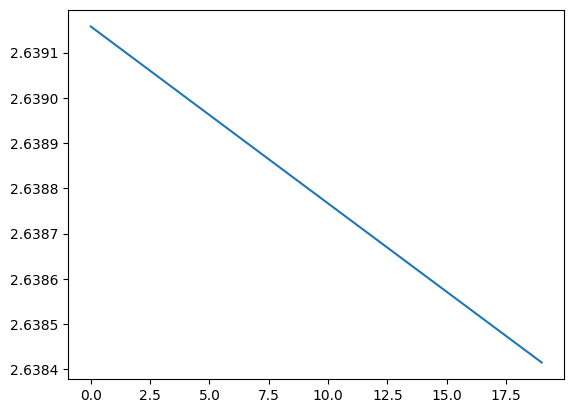

In [101]:
import matplotlib.pyplot as plt
avg_loss = []
forward_time = []
backward_time = []
numEpochs = 20
bs = 1
lr = 0.001
loop = tqdm(range(numEpochs))
for i in loop:
    c0 = train_images[0].reshape(1,1,28,28).astype(np.float32)
    sfts = time.time() # slow forward time start
    # Forward
    c1s,mask1s = Slow_ReLU_Conv(c0.astype(np.float32),k1,bc1,pad=1,stride=2)
    c2s,mask2s = Slow_ReLU_Conv(c1s.astype(np.float32),k2,bc2,pad=1,stride=2)
    c3s,mask3s = Slow_ReLU_Conv(c2s.astype(np.float32),k3,bc3,pad=1,stride=2)
    imlps = c3s.reshape(1,-1)
    fl,fa,sl,sa = ReLU_SoftMax_FullyConnected(imlps,w1,b1,w2,b2)
    sfte = time.time() # slow forward time end
    sft = sfte - sfts
    forward_time.append(sft)
    # Loss
    loss = crossEntropy(sa,train_labels[0])
    avg_loss.append(loss)

    # Backward
    sbts = time.time() # slow backward time start
    dL_i_mlp,dL_dw1,dL_db1,dL_dw2,dL_db2 = ReLU_SoftMax_FC_Backward(bs,sa,train_labels[0],w1,w2,fa,fl,imlps)
    dL_i_mlp = dL_i_mlp.reshape(c3s.shape)
    gi3,gk3,gb3 = Slow_ReLU_FullConv(c2s,dL_i_mlp,k3,mask3s,pad=1,stride=2)
    gi2,gk2,gb2 = Slow_ReLU_FullConv(c1s,gi3,k2,mask2s,pad=1,stride=2)
    gi1,gk1,gb1 = Slow_ReLU_FullConv(c0,gi2,k1,mask1s,pad=1,stride=2)
    sbte = time.time() # slow backward time end
    sbt = sbte - sbts
    backward_time.append(sbt)

    # Weights update
    w1 -= lr*dL_dw1
    b1 -= lr*dL_db1
    w2 -= lr*dL_dw2
    b2 -= lr*dL_db2
    k3 -= lr*gk3
    k2 -= lr*gk2
    k1 -= lr*gk1
    bc3 -= lr*gb3
    bc2 -= lr*gb2
    bc1 -= lr*gb1
    
    if len(avg_loss) > 2:
        loop.set_postfix(pendence=f" {avg_loss[i]-avg_loss[i-1]}",avgForward=f"{avgList(forward_time)} s", avgBackward=f"{avgList(backward_time)} s" )

plt.plot(avg_loss)

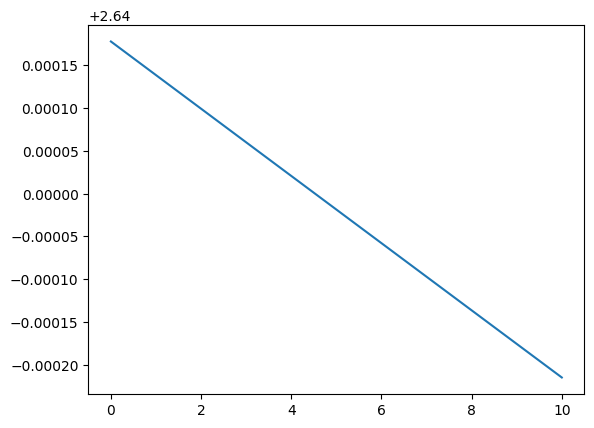

In [ ]:
plt.plot(avg_loss)

# 2.64135 <-> 2.64095
# 2.64055 <-> 2.64020
# 2.64015 <-> 2.63980